As part of creating the new editor_month table ([T362594](https://phabricator.wikimedia.org/T362594)), I'm going to re-run the backfill with a tiny fix in the query so that edits during the first second of the following month are not mistakenly included.

I want to verify that this produces only a tiny reduction in the number of edits in each month.

In [20]:
import pandas as pd

import wmfdata as wmf

In [21]:
wmf.spark.create_session(type="yarn-large")

24/07/12 00:25:08 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
24/07/12 00:25:08 WARN Utils: Service 'sparkDriver' could not bind on port 12000. Attempting port 12001.
24/07/12 00:25:08 WARN Utils: Service 'sparkDriver' could not bind on port 12001. Attempting port 12002.
24/07/12 00:25:08 WARN Utils: Service 'sparkDriver' could not bind on port 12002. Attempting port 12003.
24/07/12 00:25:08 WARN Utils: Service 'sparkDriver' could not bind on port 12003. Attempting port 12004.
24/07/12 00:25:08 WARN Utils: Service 'sparkDriver' could not bind on port 12004. Attempting port 12005.
24/07/12 00:25:08 WARN Utils: Service 'sparkDriver' could not bind on port 12005. Attempting port 12006.
24/07/12 00:25:08 WARN Utils: Service 'sparkDriver' could not bind on port 12006. Attempting port 12007.
24/07/12 00:25:08 WARN Utils: Service 'sparkDriver' could not bind o

## Before backfill

In [8]:
old_monthly_edit_count = (
    wmf.presto.run("""
        SELECT
            month,
            SUM(edit_count) AS edit_count
        FROM wmf_contributors.editor_month
        GROUP BY month
        ORDER BY month
    """, catalog="analytics_iceberg")
    .assign(month=lambda df: pd.to_datetime(df["month"]))
    .set_index("month")
)

## After backfill

In [12]:
new_monthly_edit_count = (
    wmf.presto.run("""
        SELECT
            month,
            SUM(edit_count) AS edit_count
        FROM wmf_contributors.editor_month
        GROUP BY month
        ORDER BY month
    """, catalog="analytics_iceberg")
    .assign(month=lambda df: pd.to_datetime(df["month"]))
    .set_index("month")
)

## Comparison

In [14]:
change = new_monthly_edit_count - old_monthly_edit_count

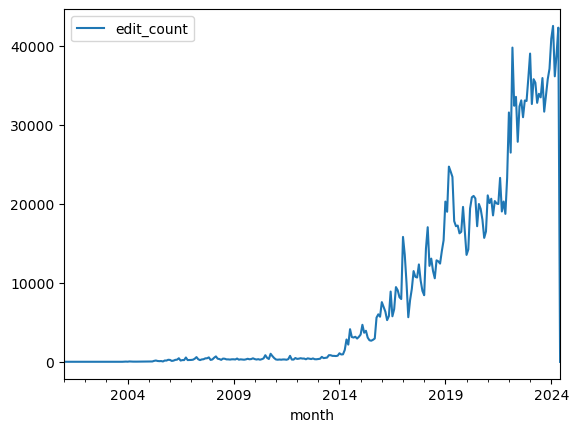

In [23]:
change.plot();

In [24]:
change.tail()

edit_count
month                 
2024-02-01       42512
2024-03-01       36133
2024-04-01       38897
2024-05-01       42291
2024-06-01         -19

What?! The last value is what I expected, but the values from 2014 to 2024-05 are way higher than they should be.

Well, okay. One crucial difference is that I did the new run on the 2024-06 snapshot of mediawiki_history, while I did the old run on the 2024-05 snapshot, *except* for the old 2024-06 value which was built by the Airflow job using the 2024-06 snapshot. Mediawiki_history does shift between snapshots, so it would fit if the changes were all due to the shift between the two snapshots.

But the shift here is a lot larger than it should be for just a single month. In my [recent investigation of mediawiki_history shift](https://gitlab.wikimedia.org/nshahquinn-wmf/editor-month-history-shift), a single month led to an extra 3,100 edits. It took nine months to see a shift greater than 42,000 edits. I did see that the time bounds bug caused an increase of 14 edits in 2024-05, so the decrease of 19 in 2024-06 from fixing it is consistent, at least.

Hmm. I don't really want to do another investigation right now, but I think I have to. In this case, if we look at 2024-05, we can compare the two snapshots of mediawiki_history and find the rows which don't match.

In [26]:
wmf.spark.create_session(type="yarn-large")

SPARK_HOME: /srv/home/nshahquinn-wmf/.conda/envs/2024-02-23T23.25.17_nshahquinn-wmf/lib/python3.10/site-packages/pyspark
Using Hadoop client lib jars at 3.2.0, provided by Spark.
PYSPARK_PYTHON=/opt/conda-analytics/bin/python3


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/07/09 18:08:55 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
24/07/09 18:08:56 WARN Utils: Service 'sparkDriver' could not bind on port 12000. Attempting port 12001.
24/07/09 18:08:56 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/07/09 18:09:05 WARN Utils: Service 'org.apache.spark.network.netty.NettyBlockTransferService' could not bind on port 13000. Attempting port 13001.


In [ ]:
missing_revisions = wmf.spark.run("""
    WITH may_snapshot_edits AS (
        SELECT
            snapshot,
            wiki_db AS wiki_id,
            event_timestamp AS dt,
            event_user_id AS user_local_id,
            event_user_text AS user_text,
            revision_id
        FROM wmf.mediawiki_history
        LEFT JOIN canonical_data.wikis
        ON wiki_db = database_code
        WHERE
            event_entity = 'revision'
            AND event_type = 'create'
            AND snapshot = '2024-05'
            AND database_group IN (
                'commons', 'incubator', 'foundation', 'mediawiki',
                'meta', 'sources', 'species', 'wikibooks',
                'wikidata', 'wikifunctions', 'wikinews', 'wikipedia',
                'wikiquote', 'wikisource', 'wikiversity', 'wikivoyage',
                'wiktionary'
            )
            AND event_timestamp >= '2024-05'
            AND event_timestamp < '2024-06'
    ),
    june_snapshot_edits AS (
        SELECT
            snapshot,
            wiki_db AS wiki_id,
            event_timestamp AS dt,
            event_user_id AS user_local_id,
            event_user_text AS user_text,
            revision_id
        FROM wmf.mediawiki_history
        LEFT JOIN canonical_data.wikis
        ON wiki_db = database_code
        WHERE
            event_entity = 'revision'
            AND event_type = 'create'
            AND snapshot = '2024-06'
            AND database_group IN (
                'commons', 'incubator', 'foundation', 'mediawiki',
                'meta', 'sources', 'species', 'wikibooks',
                'wikidata', 'wikifunctions', 'wikinews', 'wikipedia',
                'wikiquote', 'wikisource', 'wikiversity', 'wikivoyage',
                'wiktionary'
            )
            AND event_timestamp >= '2024-05'
            AND event_timestamp < '2024-06'
    )
    SELECT *
    FROM may_snapshot_edits
    -- There is no OUTER ANTI JOIN, so we'll have to repeat with the tables
    -- reversed and UNION to get all the revisions only found in one snapshot
    LEFT ANTI JOIN june_snapshot_edits
    USING (wiki_id, revision_id)
    
    UNION
    
    SELECT *
    FROM june_snapshot_edits
    LEFT ANTI JOIN may_snapshot_edits
    USING (wiki_id, revision_id)
""")

In [77]:
missing_revisions.groupby("snapshot").apply(len)

snapshot
2024-05      16
2024-06    1530
dtype: int64

Well, once again, I'm very confused. This number of revisions present in one snapshot but missing in the other is exactly what I would expect based on the previous investigation. Yet the time pattern of the difference lines up extremely well with the idea that it was a change in mediawiki_history. Are there other possibilities?

Ideas:
- A bug accidently introduced to the SQL query while fixing the time bounds issue. But, looking at [the change](https://gitlab.wikimedia.org/repos/movement-insights/sql/-/commit/e7280b2f1630b49e6e8bb1f24aae8eef62fe1d22), it seems to be exactly what it should be. Plus, a bug should affect all months more-or-less equally, which is not what we see.
- An issue with how the query deletes the existing data for a month before inserting it; this backfill had to delete previous data, which wasn't the case for the first backfill, so such a problem would have shown up here for the first time. But, again, the code looks right even when I reexamine it, and I did test how the query handled deleting the data from a previous test run. Also, this wouldn't explain the time pattern since this backfill had to delete data for 2024-06 just like for 2024-05 and previous months.
- Some weird transient issue with either the first or second backfill. But that doesn't seem right either. Each backfill  took something like 30 hours and was composed of nearly 300 logically separate Spark jobs. What kind of transient issue could affect so many separate jobs over such a substantial period?

What else can I look at? Unfortunately the previous version of editor_month was overwritten during this second backfill, so I can't compare the two. I don't think it will be very informative, but I can compare the newest version with an even older version, from before [this project](https://phabricator.wikimedia.org/T362594) to rewrite the job.

In [45]:
old_old_monthly_edit_count = (
    wmf.presto.run("""
        SELECT
            month,
            SUM(edits) AS edit_count
        FROM wmf_product.editor_month
        GROUP BY month
        ORDER BY month
    """)
    .assign(month=lambda df: pd.to_datetime(df["month"]))
    .set_index("month")
)

In [47]:
change_from_old_old = new_monthly_edit_count - old_old_monthly_edit_count

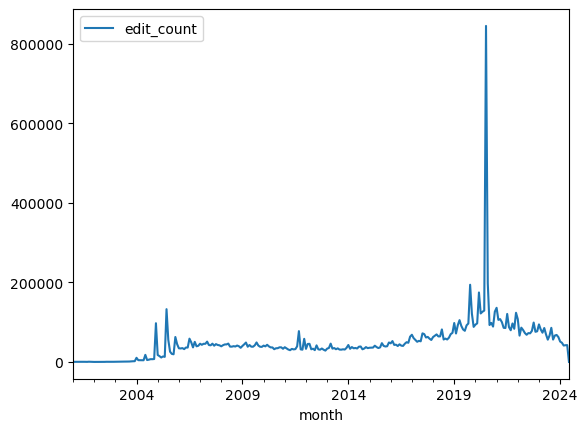

In [48]:
change_from_old_old.plot();

My takeaway from the comparison between the new version and the "old-old" version is that this shows the issues I noted during my previous investigations (like the massive spike in 2020-07) _plus_ this new issue, whatever it is. So all it really tells us is that this is probably a real issue.

Now I'm going to run a test backfill for just 2024-05, using the 2024-06 snapshot, but with the older query (without the date bounds fix). If this test stills shows the massive increase in edits, we'll know that the query change wasn't the issue.

In [57]:
old_monthly_edit_count_new_snapshot = (
    wmf.presto.run("""
        SELECT
            month,
            SUM(edit_count) AS edit_count
        FROM nshahquinn.editor_month
        GROUP BY month
        ORDER BY month
    """, catalog="analytics_iceberg")
    .assign(month=lambda df: pd.to_datetime(df["month"]))
    .set_index("month")
)

In [64]:
new_monthly_edit_count.query("month == '2024-05-01'") - old_monthly_edit_count_new_snapshot

edit_count
month                 
2024-05-01         -14

Hmm, so the only difference between the new version and this test run is that the new version is missing the 14 edits mistakenly included by the time bounds issue. So the query change was not the source of the big discrepancy.

Now let me do another test run using the new query but the 2024-05 snapshot. This should show the big discrepancy (although our direct comparison of mediawiki_history suggests that it won't).

In [67]:
new_monthly_edit_count_old_snapshot = (
    wmf.presto.run("""
        SELECT
            month,
            SUM(edit_count) AS edit_count
        FROM nshahquinn.editor_month
        GROUP BY month
        ORDER BY month
    """, catalog="analytics_iceberg")
    .assign(month=lambda df: pd.to_datetime(df["month"]))
    .set_index("month")
)

In [68]:
new_monthly_edit_count.query("month == '2024-05-01'") - new_monthly_edit_count_old_snapshot

edit_count
month                 
2024-05-01       42305

Huh! So something is different between the two snapshots causing this discrepancy, and it shows up in this query but not in the direct comparison of the two snapshots that I did.

So let's compare two versions of the 2024-05 editor_month built using the new query: one built with the 2024-05 snapshot and the other built with the 2024-06 snapshot.

In [14]:
nonmatching_rows = wmf.spark.run("""
    SELECT
        b.wiki_id,
        b.user_local_id,
        -- Occasionally users are renamed; we want the latest name if that has happened here
        b.user_name AS user_name,
        a.edit_count AS edit_count_05_snapshot,
        b.edit_count AS edit_count_06_snapshot
    FROM nshahquinn.editor_month_2024_05_snapshot a
    FULL OUTER JOIN nshahquinn.editor_month_2024_06_snapshot b
    ON 
        a.wiki_id = b.wiki_id
        -- For permanent users, we want to join on the ID to be unaffected by renames
        -- For IP users, which don't have an ID, we want to join on the name
        AND COALESCE(a.user_local_id, a.user_name) = COALESCE(b.user_local_id, b.user_name)
    WHERE
        -- Cases where either row was missing (NULL edit count) or where the edit counts
        -- did not match
        COALESCE(a.edit_count, 0) != COALESCE(b.edit_count, 0)
""")

In [15]:
nonmatching_rows = nonmatching_rows.assign(
    user_local_id=lambda df: df["user_local_id"].astype("Int64"),
    edit_count_05_snapshot=lambda df: df["edit_count_05_snapshot"].astype("Int64"),
    edit_count_06_snapshot=lambda df: df["edit_count_06_snapshot"].astype("Int64")
)

In [4]:
nonmatching_rows.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6291 entries, 0 to 6290
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   wiki_id                 6207 non-null   object
 1   user_local_id           4894 non-null   Int64 
 2   user_name               6143 non-null   object
 3   edit_count_05_snapshot  5849 non-null   Int64 
 4   edit_count_06_snapshot  6207 non-null   Int64 
dtypes: Int64(3), object(2)
memory usage: 264.3+ KB


In [119]:
nonmatching_rows["edit_count_06_snapshot"].sum() - nonmatching_rows["edit_count_05_snapshot"].sum()

42305

Good, the discrepancy we've been chasing is captured in this dataset.

In [111]:
null_wiki = nonmatching_rows.query("wiki_id.isna()")
null_wiki

wiki_id  user_local_id user_name  edit_count_05_snapshot  \
0       None           <NA>      None                       5   
6       None           <NA>      None                       5   
56      None           <NA>      None                       1   
58      None           <NA>      None                       5   
76      None           <NA>      None                       2   
...      ...            ...       ...                     ...   
5486    None           <NA>      None                       4   
6158    None           <NA>      None                      42   
6256    None           <NA>      None                       3   
6257    None           <NA>      None                       1   
6272    None           <NA>      None                      33   

      edit_count_06_snapshot  
0                       <NA>  
6                       <NA>  
56                      <NA>  
58                      <NA>  
76                      <NA>  
...                      ...  
5486                    <NA>  
6158                    <NA>  
6256                    <NA>  
6257                    <NA>  
6272                    <NA>  

[84 rows x 5 columns]

In [112]:
null_wiki.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 84 entries, 0 to 6272
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   wiki_id                 0 non-null      object
 1   user_local_id           0 non-null      Int64 
 2   user_name               0 non-null      object
 3   edit_count_05_snapshot  84 non-null     Int64 
 4   edit_count_06_snapshot  0 non-null      Int64 
dtypes: Int64(3), object(2)
memory usage: 4.2+ KB


In [113]:
null_wiki["edit_count_05_snapshot"].sum()

4777

Okay, so we have 4,777 edits in the 05 snapshot where the `wiki_db` was apparently null, which should definitely not happen. 

In [114]:
mwh_null_wiki = wmf.spark.run("""
    SELECT *
    FROM wmf.mediawiki_history
    WHERE
        snapshot = '2024-05'
        AND wiki_db IS NULL
""")

In [116]:
mwh_null_wiki

Empty DataFrame
Columns: [wiki_db, event_entity, event_type, event_timestamp, event_comment, event_user_id, event_user_text_historical, event_user_text, event_user_blocks_historical, event_user_blocks, event_user_groups_historical, event_user_groups, event_user_is_bot_by_historical, event_user_is_bot_by, event_user_is_created_by_self, event_user_is_created_by_system, event_user_is_created_by_peer, event_user_is_anonymous, event_user_registration_timestamp, event_user_creation_timestamp, event_user_first_edit_timestamp, event_user_revision_count, event_user_seconds_since_previous_revision, page_id, page_artificial_id, page_title_historical, page_title, page_namespace_historical, page_namespace_is_content_historical, page_namespace, page_namespace_is_content, page_is_redirect, page_is_deleted, page_creation_timestamp, page_first_edit_timestamp, page_revision_count, page_seconds_since_previous_revision, user_id, user_text_historical, user_text, user_blocks_historical, user_blocks, user_groups_historical, user_groups, user_is_bot_by_historical, user_is_bot_by, user_is_created_by_self, user_is_created_by_system, user_is_created_by_peer, user_is_anonymous, user_registration_timestamp, user_creation_timestamp, user_first_edit_timestamp, revision_id, revision_parent_id, revision_minor_edit, revision_deleted_parts, revision_deleted_parts_are_suppressed, revision_text_bytes, revision_text_bytes_diff, revision_text_sha1, revision_content_model, revision_content_format, revision_is_deleted_by_page_deletion, revision_deleted_by_page_deletion_timestamp, revision_is_identity_reverted, revision_first_identity_reverting_revision_id, revision_seconds_to_identity_revert, revision_is_identity_revert, revision_is_from_before_page_creation, revision_tags, snapshot]
Index: []

[0 rows x 72 columns]

And yet when I go look at mediawiki_history directly, there isn't anything like that.

Poking at the dataset more, I noticed one case where there are two rows in the 06 snapshot for the same revision. How often has this happened?

In [9]:
wmf.spark.run("""
    WITH rev_id_frequencies AS (
        SELECT
            COUNT(*) AS frequency
        FROM wmf.mediawiki_history
        WHERE
            event_entity = 'revision'
            AND event_type = 'create'
            AND snapshot = '2024-06'
            AND event_timestamp >= '2024-05'
            AND event_timestamp < '2024-06'
        GROUP BY
            wiki_db,
            revision_id
    )
    SELECT
        COUNT(*) AS revisions_with_duplicates_count,
        SUM(frequency - 1) AS duplicate_count
    FROM rev_id_frequencies
    WHERE frequency > 1
""")

revisions_with_duplicates_count  duplicate_count
0                            20513            40753

Eureka! Looking at May only, there are 40,753 duplicates, which is pretty much _exactly_ the size of the "extra" increase in edits between the snapshots that I've been trying to explain.

Querying the MediaWiki databases directly for the revision where I first noticed the problem gave only one row, confirming that the problem is a bug in the generation of mediawiki_history.

In [11]:
wmf.mariadb.run("""
    SELECT *
    FROM revision
    WHERE rev_id = 1223822196
""", "enwiki")

rev_id  rev_page  rev_comment_id  rev_actor   rev_timestamp  \
0  1223822196  68526738              10  230525687  20240514154249   

   rev_minor_edit  rev_deleted  rev_len  rev_parent_id  \
0               0            0     8416     1221161732   

                          rev_sha1  
0  96y6zhkgvi1iwsnjr1hchqmr0wmbcel

Expanding our focus from just edits during 2024-05 to the whole snapshot, how many duplicate edits are there?

In [12]:
wmf.spark.run("""
    WITH rev_id_frequencies AS (
        SELECT
            COUNT(*) AS frequency
        FROM wmf.mediawiki_history
        WHERE
            event_entity = 'revision'
            AND event_type = 'create'
            AND snapshot = '2024-06'
        GROUP BY
            wiki_db,
            revision_id
    )
    SELECT
        COUNT(*) AS revisions_with_duplicates_count,
        SUM(frequency - 1) AS duplicate_count
    FROM rev_id_frequencies
    WHERE frequency > 1
""")

revisions_with_duplicates_count  duplicate_count
0                          1080128          2146208

Out of curiosity, what share of the total edits in the snapshot do the duplicates represent?

In [13]:
edit_count = wmf.spark.run("""
    SELECT
        COUNT(*) AS edit_count
    FROM wmf.mediawiki_history
    WHERE
        event_entity = 'revision'
        AND event_type = 'create'
        AND snapshot = '2024-06'
""").iloc[0, 0]

In [14]:
edit_count

7113050908

In [26]:
wmf.utils.pct_str(_12.loc[0, "duplicate_count"] / edit_count, decimals=3)

'0.030%'

Also, how often did this happen in the 05 snapshot?

In [11]:
duplicates_05_snapshot = wmf.spark.run("""
    WITH rev_id_frequencies AS (
        SELECT
            COUNT(*) AS frequency
        FROM wmf.mediawiki_history
        WHERE
            event_entity = 'revision'
            AND event_type = 'create'
            AND snapshot = '2024-05'
        GROUP BY
            wiki_db,
            revision_id
    )
    SELECT
        COUNT(*) AS revisions_with_duplicates_count,
        SUM(frequency - 1) AS duplicate_count
    FROM rev_id_frequencies
    WHERE frequency > 1
""")

24/07/11 16:28:22 WARN SessionState: METASTORE_FILTER_HOOK will be ignored, since hive.security.authorization.manager is set to instance of HiveAuthorizerFactory.


In [13]:
duplicates_05_snapshot

revisions_with_duplicates_count  duplicate_count
0                                0              NaN

Interesting! Not at all. So this is an entirely new problem.

I also want to understand how this is likely to affect the 2024-06 editing metrics which we calculated from the new snapshot. First, what was the share of duplicate revisions in 2024-05 and 2024-06?

In [6]:
duplicates = wmf.spark.run("""
    WITH rev_id_frequencies AS (
        SELECT
            DATE_FORMAT(event_timestamp, 'yyyy-MM-01') AS month,
            COUNT(*) AS frequency
        FROM wmf.mediawiki_history
        WHERE
            event_entity = 'revision'
            AND event_type = 'create'
            AND snapshot = '2024-06'
            AND event_timestamp >= '2024-05'
            AND event_timestamp < '2024-07'
        GROUP BY
            DATE_FORMAT(event_timestamp, 'yyyy-MM-01'),
            wiki_db,
            revision_id
    )
    SELECT
        month,
        SUM(frequency) AS edit_count,
        SUM(frequency - 1) AS duplicate_edit_count
    FROM rev_id_frequencies
    GROUP BY month
""")

In [12]:
def pct_str(n):
    return wmf.utils.pct_str(n, decimals=2)

(
    duplicates
    .assign(
        month=lambda df: pd.to_datetime(df["month"]),
        duplicate_share_of_edits=lambda df: (df["duplicate_edit_count"] / df["edit_count"]).map(pct_str)
    )
    .sort_values("month")
    .set_index("month")
)

edit_count  duplicate_edit_count duplicate_share_of_edits
month                                                                
2024-05-01    52247874                 40753                    0.08%
2024-06-01    49678493                 34888                    0.07%

Looking at the rows that didn't match when we compared the May editor-month rows between the 05 snapshot and 06 snapshot, how many permanent editors hit a threshold of 5 edits per month because of the duplicates? This isn't exactly the same as the effect on active editors, since there the threshold is 5 *content* edits per month, but it should give us a ceiling on the impact on active editors (since the number of editors virtually always decreases as you go to a higher edit count, and having at least 5 content edits requires having at least 5 total edits). 

In [26]:
(
    nonmatching_rows
    .query("~user_local_id.isna() and edit_count_05_snapshot < 5 and edit_count_06_snapshot >= 5")
    .shape[0]
)

87

So the impact on May active editors would have been no more than 87 additional active editors.